# Reinforcement Learning: Learning to Play Tic-Tac-Toe with Q-Learning

## Introduction 
 
The goal of reinforcement learning is to interact with the environment and use trial-and-error to learn the best action for each state. Prescribing an action for a state is called a policy. The optimal policy is the policy that maximizes the sum of
all future expected rewards. 

The optimal action in a state $s$ can be determined from the Q-values $Q(s, a)$ which is the expected utility of
choosing $a$ in $s$ and the following the current policy till a terminal state is reached. The optimal action is the 
action with the largest Q-value for the state. The policy implementing this idea is called a greedy policy. 

For small problems, the Q-value function can be expressed as a table. 
We implement here the table-based TD(0) algorithm as described in Chapter 6 of Sutton and Barto (2020). 

> **Algorithm: Q-learning (off-policy TD control) for estimating $\pi^*$**
> 
> Parameters: step size $\alpha \in (0, 1]$, small $\epsilon > 0$, a discount factor $\gamma$
> 
> Initialize $Q(s, a) = 0$, for all $s \in S^+, a \in A(s)$
> 
> Loop for each episode:
>   * Initialize $s$
>   * Loop for each step of episode:
>     *  Choose $a$ for $s$ (the state in the current step) using a policy derived from $Q$ (e.g., $\epsilon$-greedy)
>     *  Take action $a$, observe the reward $r$ and the next state $s'$
>     *  $Q(s, a) \leftarrow Q(s, a) + \alpha [r +  \gamma \max_{a'} Q(s', a') - Q(s, a)]$
>     *  $s \leftarrow s'$
>   * until $s$ is terminal
 
The idea of this iterative algorithm is to make in every step $Q(s, a)$ a little more similar to 
the immediate reward plus the expected utility of the best action in the next state expressed as $r + Q(s', a')$. The algorithm is called temporal differencing since it used the 
difference between Q-values at state $s$ and the next (i.e., later) state $s'$. This difference is also
called the TD-error which the algorithm tries to minimize. The algorithm explores using an $\epsilon$-greedy which uses with a probability of $\epsilon$ a random action 
instead of the greedy (best) action.

Different to the description in Sutton and Batro (2020), we will implement the algorithm as an agent function that can interact with an environment. An example is shown in AIMA Figure 22.8.

Also, there is no immediate reward in games like tic-tac-toe. The reward is only available when the game ends. This delayed reward make the problem harder since we do not
know if an action was good or bad till the game ends.

Install missing libraries.

In [19]:
%pip install -q numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


## Q-Table Size

First, we need to establish that the Q-table will fit in memory. The table implements the function $Q: S \times A \rightarrow \mathbb{R}$ so it has number of states times number of actions entries.

We can estimate this in the following way:

In [20]:
import math

print("level\tboards\tactions\tQ table entries")
sum = 0

for i in range(0,9):
    # unique states at each level:
    # how many squares are played times how we can split them between x and o
    boards = math.comb(9, i) * math.comb(i, math.floor(i/2))
    actions = 9 - i
    print(i, "\t", 
          boards, "\t",
          actions, "\t",
          boards * actions)
    sum += boards * actions

sum

level	boards	actions	Q table entries
0 	 1 	 9 	 9
1 	 9 	 8 	 72
2 	 72 	 7 	 504
3 	 252 	 6 	 1512
4 	 756 	 5 	 3780
5 	 1260 	 4 	 5040
6 	 1680 	 3 	 5040
7 	 1260 	 2 	 2520
8 	 630 	 1 	 630


19107

This game has no cycles and combinatorics takes care of redundant paths so all states are unique.
However, some boards are not reachable since the game is over once one player wins. Given this analysis, the Q-table should easily fit in memory and
learning all these values should not take too much time.

## Define the Environment for the RL Agent
We already have functions implementing the game mechanics in [tictactoe.py](tictactoe.py).

In [21]:
from tictactoe import empty_board, actions, result, terminal, utility, other, show_board
import numpy as np

Create a random agent as a class. `act()` is the agent function. For RL, the agent gets new observations and the reward for the previous action. 

In [22]:
class RandomAgent:
    def __init__(self, symbol):
        self.symbol = symbol

    # we ignore the reward for this agent
    def act(self, observation, reward = 0, terminal = False):
        if terminal:
            return None
        return np.random.choice(actions(observation))

We define a RL environment that has only sample access where episodes can be sampled. Episodes are self-contained sequences from a start state to a terminal state of the sequence. Here an episode is a game.

The game is fully observable. So the observation is the complete state represented by the board. We therefore use state or observation here meaning the same. The environment keeps track of the current state.

The environment contains the opponent, so we need to specify the opponent's behavior. We use a simple agent function that maps observations to an action. By default we use a random player.

In [23]:
class environment_tictactoe:
    # Initialize the environment with an opponent
    # opponent is an agent object that has a act() method.
    def __init__(self, symbol = "x", opponent = RandomAgent("o")):
        self.state = empty_board()
        if symbol not in ["x", "o"]:
            raise ValueError("Player must be 'x' or 'o'")
        self.symbol = symbol

        if opponent.symbol not in [s for s in ["x", "o"] if s != self.symbol]:
            raise ValueError("Player must be 'x' or 'o' and different from the agent's symbol")
        self.opponent = opponent

    # reset the environment to the initial state
    # returns the initial state, reward (0), and whether the episode is done (False)
    # if we play o, the opponent (x) needs to make the first move
    def reset(self):
        self.state = empty_board()
        
        # x needs to make the first move if we play o
        if self.symbol == "o":
            self.state = result(self.state, 
                                self.opponent.symbol, 
                                self.opponent.act(self.state, 0, False))
        
        return self.state, 0, False

    # execute an agent action in the environment
    # returns the new state, reward, and whether the episode is done
    def step(self, action):
        if action not in actions(self.state):
            raise ValueError("Invalid action")
        
        # execute agent's action
        self.state = result(self.state, self.symbol, action)
        
        # opponent (the other player) makes a move
        if not terminal(self.state):
            self.state = result(self.state, 
                                self.opponent.symbol, 
                                self.opponent.act(self.state, 0, False))
        else:
            # show the opponent the final board
            self.opponent.act(self.state, utility(self.state, self.opponent.symbol), True)  
        
        reward = 0
        term = False
        if terminal(self.state):
            reward = utility(self.state, self.symbol)
            term = True
        
        return self.state, reward, term

    # visualize the current state of the environment
    def render(self):
        show_board(self.state)

Try a move in this environment using `step()`.

([' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '], 0, False)


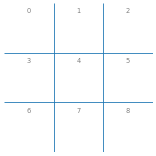

(['x', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'o'], 0, False)


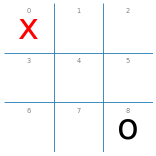

In [24]:
env = environment_tictactoe(symbol="x", opponent=RandomAgent("o"))
print(env.reset())
env.render()

print(env.step(0))
env.render()

Sample a whole episode, that is play a game randomly to the end. In search-based AI this is also called a playout. Here we use a random player for the agent.

Action: 8, Observation: [' ', ' ', ' ', ' ', ' ', 'o', ' ', ' ', 'x'], Reward: 0, Terminal: False
Action: 2, Observation: [' ', ' ', 'x', ' ', 'o', 'o', ' ', ' ', 'x'], Reward: 0, Terminal: False
Action: 0, Observation: ['x', 'o', 'x', ' ', 'o', 'o', ' ', ' ', 'x'], Reward: 0, Terminal: False
Action: 7, Observation: ['x', 'o', 'x', ' ', 'o', 'o', 'o', 'x', 'x'], Reward: 0, Terminal: False
Action: 3, Observation: ['x', 'o', 'x', 'x', 'o', 'o', 'o', 'x', 'x'], Reward: 0, Terminal: True


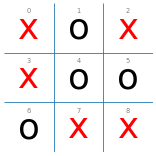

In [25]:
agent = RandomAgent("x")

observation, reward, term = env.reset()

while not term:
    # choose random action
    action = agent.act(observation)
    
    # update the environment with the chosen action
    observation, reward, term = env.step(action)
    
    print(f"Action: {action}, Observation: {observation}, Reward: {reward}, Terminal: {term}")

env.render()

## Implement Q-Learning

We need argmax which randomly breaking ties so we implement a helper function.

In [26]:
def argmax_rand(b):
    return np.random.choice(np.flatnonzero(b == np.max(b)))

The agent stores the Q table learned so far as a hash table (dictionary). The key is the state/observation and the action. The value is the Q-value. The agent also stores the previous state and action since they are needed for the Q-learning update:

$Q(s, a) \leftarrow Q(s, a) + \alpha [r +  \gamma \max_{a'} Q(s', a') - Q(s, a)]$

Here $s$ and $a$ are the previous state and action. $r$ is the observed reward and $s'$ the resulting state from action $a$. The agent choses the next action $a'$. 

In [27]:
DEBUG = True

class QAgent:
    def __init__(self, symbol = 'x', epsilon = 0.1, alpha = 0.1, gamma = 0.9):
        self.symbol = symbol
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
       
        self.Q = dict() # Q-table, empty means all entries are initially 0
        self.s = None # previous state
        self.a = None # previous action
        if DEBUG:
            print("Initializing QAgent with symbol", symbol, "epsilon", epsilon, "alpha", alpha, "gamma", gamma)
        
    # Clear the agent's Q-table
    def reset(self):
        self.Q = dict()
        self.s = None
        self.a = None
        if DEBUG:
                print("Resetting QAgent")

    # Update the Q-table based on the current state, action, and reward
    def update(self, observation, reward, terminal = False):
        s_prime = observation
        
        if self.s is None or self.a is None:
            return
        
        Q_s_a = self.Q.get((tuple(self.s), self.a), 0)

        # Update Q-table with final reward, no more actions possible
        if (terminal): 
            Q_s_a = Q_s_a + self.alpha * (reward - Q_s_a)
            # Note: in a deterministic environment, we could directly set the Q-value with to the final reward
            # Q_s_a = reward, but here the opponent introduced non-determinism

            self.Q[(tuple(self.s), self.a)] = Q_s_a
            if DEBUG:
                print("Updating Q-table for state", self.s, "and action", self.a, "with reward", reward)

            self.s = None
            self.a = None
            return None
     
        # Update Q-table while game is not over
        if self.s is not None and self.a is not None:
            max_Q_sp_ap = np.max([self.Q.get((tuple(s_prime), x), 0) for x in actions(s_prime)])
            
            # Q-learning update rule
            Q_s_a = Q_s_a + self.alpha * (reward + self.gamma * max_Q_sp_ap - Q_s_a)
            
            self.Q[(tuple(self.s), self.a)] = Q_s_a

            if DEBUG:
                print("Updating Q-table for state", self.s, "and action", self.a, "to", self.Q[(tuple(self.s), self.a)])
  
    # Choose an action based on the current state (epsilon-greedy strategy to balance exploration and exploitation)
    def choose_action(self, observation):
        s = observation

        # Determine new action using epsilon-greedy strategy
        if np.random.uniform() < self.epsilon:
            # random action
            a = np.random.choice(actions(s))
            if DEBUG:
                print("Chosen random action:", a)
        else:
            # greedy action (best action given current Q-values)
            a = actions(s)[argmax_rand([self.Q.get((tuple(s), x), 0) for x in actions(s)])]
            if DEBUG:
                print("Chosen greedy action:", a)

        return a
    
    # agent function: update the Q-table and then choose an action
    def act(self, observation, reward = None, terminal = False):
        # update Q-table
        if reward is not None:
            self.update(observation, reward, terminal)
        
        # choose next action
        if not terminal:
            a = self.choose_action(observation)
        else: 
            a = None
        
        # remember last observation and action
        self.s = observation
        self.a = a
        
        return a    

Initializing QAgent with symbol x epsilon 0.1 alpha 0.1 gamma 0.9
Chosen greedy action: 6
Action: 6, Observation: [' ', ' ', ' ', ' ', ' ', ' ', 'x', 'o', ' '], Reward: 0, Terminal: False
Updating Q-table for state [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '] and action 6 to 0.0
Chosen greedy action: 3
Action: 3, Observation: [' ', 'o', ' ', 'x', ' ', ' ', 'x', 'o', ' '], Reward: 0, Terminal: False
Updating Q-table for state [' ', ' ', ' ', ' ', ' ', ' ', 'x', 'o', ' '] and action 3 to 0.0
Chosen greedy action: 2
Action: 2, Observation: [' ', 'o', 'x', 'x', 'o', ' ', 'x', 'o', ' '], Reward: -1, Terminal: True
Updating Q-table for state [' ', 'o', ' ', 'x', ' ', ' ', 'x', 'o', ' '] and action 2 with reward -1


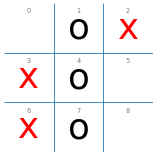

In [28]:
agent = QAgent()

observation, reward, term = env.reset()

while not term:
    action = agent.act(observation, reward, term)
    observation, reward, term = env.step(action)
    print(f"Action: {action}, Observation: {observation}, Reward: {reward}, Terminal: {term}")

# we need to show the agent the final board
agent.act(observation, reward, term)

env.render()  

Learned Q-table after one game.

In [29]:
agent.Q

{((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '), 6): np.float64(0.0),
 ((' ', ' ', ' ', ' ', ' ', ' ', 'x', 'o', ' '), 3): np.float64(0.0),
 ((' ', 'o', ' ', 'x', ' ', ' ', 'x', 'o', ' '), 2): -0.1}

## Experiments

### Repeated Playing


In [30]:
def play(agent, opponent, N = 100):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    results = {'x': 0, 'o': 0, 'd': 0}
    
    env = environment_tictactoe(agent.symbol, opponent=opponent)

    for i in range(N):
        observation, reward, term = env.reset()

        while not term:
            action = agent.act(observation, reward, term)
            observation, reward, term = env.step(action)

        # we need to show the agent the final board so it
        agent.act(observation, reward, term)

        
        if (reward == 1):
            results[agent.symbol] += 1
        elif (reward == -1):
            results[opponent.symbol] += 1
        else:
            results['d'] += 1       
                
    return results

## Q-Learning Agent vs. Random

The agent learns for every game that it plays. 
We start with the first 100 games to see how bad it initially is.
I reduce the learning rate $\alpha$ and for the final 1000 games, we set $\epsilon = 0$ so the 
agent only makes greedy moves.

The hyperparameters $\epsilon$ and $\alpha$ could be tuned.


### Train a Q-learning agent for playing x

In [31]:
print("Q-Learning vs. Random:")

DEBUG = False

q_player_x = QAgent(symbol = 'x', epsilon = 0.3, alpha = 0.2)
q_player_x.reset()

random_player_o = RandomAgent(symbol = 'o')

print("Initially, the performance is not better than a random player!")
display(play(q_player_x, random_player_o, N = 100))

print("Play to learn how to play against a random player.")
display(play(q_player_x, random_player_o, N = 5000))
display(play(q_player_x, random_player_o, N = 5000))
display(play(q_player_x, random_player_o, N = 5000))
display(play(q_player_x, random_player_o, N = 5000))
display(play(q_player_x, random_player_o, N = 5000))
display(play(q_player_x, random_player_o, N = 5000))
display(play(q_player_x, random_player_o, N = 5000))
display(play(q_player_x, random_player_o, N = 5000))

print("Reducing alpha")
q_player_x.alpha = 0.1
display(play(q_player_x, random_player_o, N = 5000))
print("Reducing alpha")
q_player_x.alpha = 0.01
display(play(q_player_x, random_player_o, N = 5000))

print("Set epsilon to zero to make the agent greedy and play again:")
q_player_x.epsilon = 0.0
display(play(q_player_x, random_player_o, N = 1000))

print("Q-table size:", len(q_player_x.Q))
q_player_x.Q

Q-Learning vs. Random:
Initially, the performance is not better than a random player!


{'x': 61, 'o': 27, 'd': 12}

Play to learn how to play against a random player.


{'x': 3981, 'o': 608, 'd': 411}

{'x': 4291, 'o': 398, 'd': 311}

{'x': 4351, 'o': 362, 'd': 287}

{'x': 4401, 'o': 376, 'd': 223}

{'x': 4462, 'o': 306, 'd': 232}

{'x': 4421, 'o': 354, 'd': 225}

{'x': 4466, 'o': 307, 'd': 227}

{'x': 4468, 'o': 307, 'd': 225}

Reducing alpha


{'x': 4418, 'o': 336, 'd': 246}

Reducing alpha


{'x': 4502, 'o': 262, 'd': 236}

Set epsilon to zero to make the agent greedy and play again:


{'x': 994, 'o': 0, 'd': 6}

Q-table size: 6464


{((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '),
  6): np.float64(0.7293037888676978),
 ((' ', ' ', ' ', 'o', ' ', ' ', 'x', ' ', ' '),
  2): np.float64(0.700297224624964),
 ((' ', ' ', 'x', 'o', ' ', 'o', 'x', ' ', ' '),
  np.int64(0)): np.float64(-0.15634927998058148),
 (('x', 'o', 'x', 'o', ' ', 'o', 'x', ' ', ' '),
  8): np.float64(-0.061416899631356284),
 ((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '),
  7): np.float64(0.6637005709152228),
 ((' ', 'o', ' ', ' ', ' ', ' ', ' ', 'x', ' '),
  np.int64(5)): np.float64(0.050449664776465196),
 ((' ', 'o', 'o', ' ', ' ', 'x', ' ', 'x', ' '), 6): np.float64(-0.2),
 ((' ', 'o', 'o', ' ', ' ', 'x', 'x', 'x', 'o'), np.int64(3)): -0.2,
 ((' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '),
  np.int64(3)): np.float64(0.6980235894351962),
 ((' ', ' ', ' ', 'x', ' ', ' ', 'o', ' ', ' '),
  np.int64(8)): np.float64(0.06592680278230303),
 ((' ', 'o', ' ', 'x', ' ', ' ', 'o', ' ', 'x'),
  np.int64(4)): np.float64(0.13281408000000003),
 ((' ', 'o', ' ', '

### Train a Q-learning agent for playing o.

In [32]:
print("Random vs. Q-Learning:")

DEBUG = False

q_player_o = QAgent(symbol = 'o', epsilon = 0.3, alpha = 0.2)
q_player_o.reset()

random_player_x = RandomAgent(symbol = 'x')

print("Initially, the performance is not better than a random player!")
display(play(q_player_o, random_player_x, N = 100))

print("Play to learn how to play against a random player.")
display(play(q_player_o, random_player_x, N = 5000))
display(play(q_player_o, random_player_x, N = 5000))
display(play(q_player_o, random_player_x, N = 5000))
display(play(q_player_o, random_player_x, N = 5000))
display(play(q_player_o, random_player_x, N = 5000))
display(play(q_player_o, random_player_x, N = 5000))
display(play(q_player_o, random_player_x, N = 5000))
display(play(q_player_o, random_player_x, N = 5000))

print("Reducing alpha")
q_player_o.alpha = 0.1
display(play(q_player_o, random_player_x, N = 5000))
print("Reducing alpha")
q_player_o.alpha = 0.1
display(play(q_player_o, random_player_x, N = 5000))

print("Set epsilon to zero to make the agent greedy and play again:")
q_player_o.epsilon = 0.0
display(play(q_player_o, random_player_x, N = 1000))

print("Q-table size:", len(q_player_o.Q))
q_player_o.Q

Random vs. Q-Learning:
Initially, the performance is not better than a random player!


{'x': 58, 'o': 34, 'd': 8}

Play to learn how to play against a random player.


{'x': 1740, 'o': 2596, 'd': 664}

{'x': 1025, 'o': 3353, 'd': 622}

{'x': 909, 'o': 3480, 'd': 611}

{'x': 830, 'o': 3533, 'd': 637}

{'x': 823, 'o': 3600, 'd': 577}

{'x': 774, 'o': 3605, 'd': 621}

{'x': 812, 'o': 3602, 'd': 586}

{'x': 787, 'o': 3629, 'd': 584}

Reducing alpha


{'x': 752, 'o': 3637, 'd': 611}

Reducing alpha


{'x': 815, 'o': 3606, 'd': 579}

Set epsilon to zero to make the agent greedy and play again:


{'x': 5, 'o': 928, 'd': 67}

Q-table size: 6917


{(('x', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' '),
  np.int64(1)): np.float64(0.4738928503409705),
 (('x', 'o', ' ', ' ', ' ', 'x', ' ', ' ', ' '), np.int64(8)): np.float64(0.0),
 (('x', 'o', ' ', 'x', ' ', 'x', ' ', ' ', 'o'), 2): np.float64(-0.2),
 (('x', 'o', 'o', 'x', ' ', 'x', ' ', 'x', 'o'), 6): -0.488,
 ((' ', ' ', 'x', ' ', ' ', ' ', ' ', ' ', ' '),
  4): np.float64(0.7613306541344423),
 ((' ', ' ', 'x', ' ', 'o', ' ', ' ', ' ', 'x'),
  5): np.float64(0.7359599439685303),
 (('x', ' ', 'x', ' ', 'o', 'o', ' ', ' ', 'x'), 3): 0.9999999999999998,
 ((' ', ' ', ' ', ' ', ' ', 'x', ' ', ' ', ' '),
  np.int64(1)): np.float64(0.4968923089204649),
 ((' ', 'o', ' ', 'x', ' ', 'x', ' ', ' ', ' '),
  4): np.float64(0.7246059605042918),
 ((' ', 'o', ' ', 'x', 'o', 'x', ' ', 'x', ' '),
  8): np.float64(0.6127471338660991),
 ((' ', 'o', 'x', 'x', 'o', 'x', ' ', 'x', 'o'), 0): 0.9999999762053586,
 (('x', ' ', 'x', ' ', 'o', ' ', ' ', ' ', ' '),
  np.int64(5)): np.float64(0.1873522793834659),
 ((

### Q-Learning vs. Q-Learning
Let two Q-learning agents play each other. This is called self play. Note that both agents already have been trained against a random agent.

In [33]:
# turn on a little exploration
print("exploration with epsilon = 0.3 and alpha = 0.1")
q_player_x.epsilon = 0.3
q_player_o.epsilon = 0.3
q_player_x.alpha = 0.1
q_player_o.alpha = 0.1

display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))


exploration with epsilon = 0.3 and alpha = 0.1


{'x': 2190, 'o': 1336, 'd': 1474}

{'x': 2112, 'o': 1172, 'd': 1716}

{'x': 2105, 'o': 1219, 'd': 1676}

{'x': 1988, 'o': 1208, 'd': 1804}

{'x': 2103, 'o': 1121, 'd': 1776}

The number of draws tends to go up, but agents are loosing because they are exploring.
Reduce exploration to $\epsilon = 0.2$. The agent will now play fewer random moves.

In [34]:
q_player_x.epsilon = 0.2
q_player_o.epsilon = 0.2

display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))

{'x': 1763, 'o': 802, 'd': 2435}

{'x': 1706, 'o': 801, 'd': 2493}

{'x': 1721, 'o': 796, 'd': 2483}

{'x': 1740, 'o': 731, 'd': 2529}

{'x': 1689, 'o': 821, 'd': 2490}

Let the agents play their final policy by turing exploration off ($\epsilon = 0$).

In [35]:
q_player_x.epsilon = 0
q_player_o.epsilon = 0

display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))
display(play(q_player_x, q_player_o, N = 5000))

{'x': 171, 'o': 100, 'd': 4729}

{'x': 155, 'o': 73, 'd': 4772}

{'x': 65, 'o': 36, 'd': 4899}

{'x': 6, 'o': 3, 'd': 4991}

{'x': 1, 'o': 1, 'd': 4998}

At the end, no agent should be able to win.

### Look at the Q-tables

In [36]:
print("Q-table size of x:", len(q_player_x.Q))
print("Q-table size of o:", len(q_player_o.Q))

Q-table size of x: 7517
Q-table size of o: 7207


Look at Q-table entries for a few boards. We show the action and the Q-value from the table. `nan` (i.e., not a number) means the action has not been tried and there is no Q-value in the table.

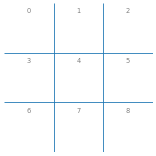

[[0, np.float64(0.0)],
 [1, np.float64(0.0)],
 [2, np.float64(0.0)],
 [3, np.float64(0.0)],
 [4, np.float64(0.0)],
 [5, np.float64(0.0)],
 [6, np.float64(0.0)],
 [7, np.float64(0.0)],
 [8, np.float64(0.0)]]

In [ ]:
Q = q_player_x.Q

def find_q(s):
    return [[x, round(Q.get((tuple(s), x), np.nan),2)] for x in actions(s)]

board = empty_board()
show_board(board)
display(find_q(board))

The agent should have learned that it does not matter, all moves will lead to a draw (0).

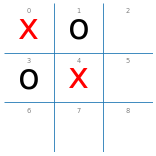

[[2, np.float64(0.17)],
 [5, np.float64(0.01)],
 [6, np.float64(0.05)],
 [7, nan],
 [8, 0.67]]

In [ ]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'
show_board(board)
display(find_q(board))

`nan` means that the agent has never tried this action for the board. Hopefully, it plays 8.

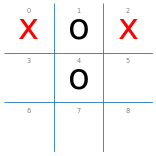

[[3, np.float64(-0.34)],
 [5, np.float64(-0.4)],
 [6, np.float64(-0.53)],
 [7, np.float64(0.0)],
 [8, np.float64(-0.59)]]

In [ ]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[2] = 'x'
board[4] = 'o'
show_board(board)
display(find_q(board))

Play 7 and draw.